# Quality of Residualization
Julian Hsu
13-aug-2023

We use this notebook to understand how the quality of residualization affects treatment estimates. We measure the quality of residualization with how well we can predict the outcome and treatment features. We use notation from Chernozhukov et al (2016) [Double-De-biased ML paper](https://arxiv.org/pdf/1608.00060.pdf). Specifically, we estimate two partial linear models using the residualized outcome, $\tilde{Y}_i = Y_i - g_0(X_i)$, and the residualized treatment, $\tilde{W}_i = W_i - m_0(X_i)$:

$$ \tilde{Y}_i = \tau W_i + \epsilon_i \hspace{5cm} (EQ 1) $$
$$ \tilde{Y}_i = \tau \tilde{W}_i + \eta_i \hspace{5cm} (EQ 2) $$

we first estimate $Y$ using a given ML model $g_0$, and then estimate an OLS regression of $Y_i - \hat{Y_i}(X_i) = \beta_0 + \tau W_i + \epsilon_i$. 


**sound byte** How important is it to iterate on the prediction parts of your double machine learnin (DML) model? I show with simulation evidence that there are diminishing returns to improving your prediction models. I show here the relationship between better predicting the outcome and treatment indicator and bias of the DML estimate. As expected, improving your prediction reduces the bias of your estimate. However, I find that there are greater benefits from reducing variation in your outcome variable. Note in these simulation have selection bias: treatment is not randomly assigned.

I'm curious how others view this, especially since residualization in only the outcome or treatment leads to bias as I find here ( [post](https://www.linkedin.com/posts/jhsuecon_causalinference-machinelearning-activity-7087083617868263424-EmCo?utm_source=share&utm_medium=member_desktop) / [notebook](https://github.com/shoepaladin/causalinference_crashcourse/blob/main/OtherMaterial/Causal%20ML%20DML%20and%20Otherwise/Causal%20Inference%20versus%20Prediction%20in%20Linear%20Regression%20Models.ipynb) ). 

Check out the notebook used to generate it here, which also does the same simulation over more complicated and non-linear data.


In [35]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score



## Write DGP Functions
Write a DGP function with a treatment indicator and confounding features.

The treatment effect will be a standard deviation of the potential control outcome.

In [113]:
def dgp(N=1000,K=3,ate_sd = 0.1
       , non_linear_degree=0
       , log = False):
    '''
    N  number of rows
    K  number of confounding variables
    ate_sd  the impact in standard deviations of the outcome
    non_linear_degree  what degree polynomial complexity we allow in outcome and treatment.
    log  whether we take the log of the feature
    '''
    
    df_out = pd.DataFrame()
    ## Create covariates
    for k in range(K):
        df_out['x{0:1.0f}'.format(k)] = np.random.uniform(1,3,N)
            
    if log==True:
        df_x_features = np.log(df_out[[e for e in df_out.columns if 'x' in e]])
    else:
        df_x_features = df_out[[e for e in df_out.columns if 'x' in e]]

    ## Create treatment indicator
    t_array = np.random.uniform(-2,2,K) 
    w_latent = np.dot(df_x_features, t_array)    
    if non_linear_degree <= 1:
        pass
    else:
        t_array0 = np.random.uniform(-2,2,K) 
        test_w=np.dot(df_x_features.pow(non_linear_degree), t_array0)        
        w_latent = w_latent + test_w
    ## Scale this down for easier computation
    w_latent /= np.var(w_latent)
    w_latent /= np.abs(np.mean(w_latent))
    w_latent = np.exp(w_latent) / (1+ np.exp(w_latent))  + np.random.uniform(0,1,N)
    df_out['w'] = ( w_latent > np.percentile(w_latent, q=50) ).astype(float)
    
    ## Create outcome 
    y_array = np.random.uniform(-0.5,0.5,K)     
    df_out['y'] = np.dot(df_x_features, y_array)
    if non_linear_degree <= 1:
        pass
    else:
        y_array0 = np.random.uniform(-2,2,K) 
        test_x = np.dot(df_x_features.pow(non_linear_degree), y_array0)  
        df_out['y'] = df_out['y'] + test_x
        df_out['test_x'] = test_x
    
    df_out['y'] += np.random.normal(0,2,N)

    ate_to_use = ate_sd * df_out['y'].std()
    df_out['y'] += df_out['w']*ate_to_use
    
    ## Scale this down for easier computation    
    df_out['y'] /= np.mean(df_out['y'])
        
    
    df_out['gt'] = ate_to_use
    
    return df_out

In [114]:
from sklearn import metrics

In [115]:
## Estimate the treatment effect with sample-splitting
## Also output the MAPE of outcome and treatment predictions
def dml_estimate(data=None,X_list=None
                , model_y=Ridge(alpha=1, fit_intercept=True)
                , model_t=LogisticRegression(penalty='l2', C=1, fit_intercept=True)):
    ml_t_model = model_t.fit(X=data[X_list], y = data['w'] )        
    w_predictions = ml_t_model.predict_proba(data[X_list])[:,1].reshape(-1,1)
    W = np.array(data['w']).reshape(-1,1) - w_predictions
    
    ml_model = model_y.fit(X=data[X_list], y = data['y'] )    
    y_predictions = ml_model.predict(data[X_list])
    YM = data['y'] - y_predictions

    ## DML Estimate from PLM Model
    
    ols_model_r = LinearRegression(fit_intercept=True).fit(X=W, y = YM)
        
        
    ## MAPE of the predictions and output
    y_score=metrics.mean_squared_error(y_true=data['y'], y_pred=y_predictions)
    w_score=metrics.roc_auc_score(y_true=data['w'], y_score=w_predictions)
    
    return ols_model_r.coef_[-1], y_score, w_score

In [116]:
## Test run to check that the code works
bias = []
for s in range(200):
    df = dgp(N=100, K=1, ate_sd = 0.5, non_linear_degree=1)
    a= dml_estimate(data=df,X_list=['x0'] 
                    , model_y=Ridge(alpha=1, fit_intercept=True)
                    , model_t=LogisticRegression(penalty='l2', C=1, fit_intercept=True) )
    if s==0:
        print('Ground Truth Impact: {0:5.3f}'.format(df['gt'][0]))
        print('DML Estimate: {0:5.3f}'.format(a[0]))
        print('Y MSE:{0:5.3f}, W MSE: {1:5.3f}'.format(a[1],a[2]))
    bias.append(df['gt'][0] - a[0])

Ground Truth Impact: 1.069
DML Estimate: 26.468
Y MSE:891.117, W MSE: 0.508


(array([  1.,   1.,   0.,   0.,   1.,   0.,   2.,  15., 174.,   6.]),
 array([-174.35420104, -153.05231468, -131.75042832, -110.44854195,
         -89.14665559,  -67.84476923,  -46.54288286,  -25.2409965 ,
          -3.93911014,   17.36277623,   38.66466259]),
 <BarContainer object of 10 artists>)

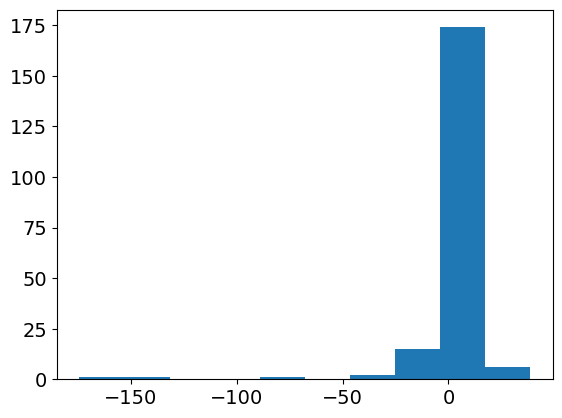

In [117]:
plt.hist(bias)

## Simulations Demonstrating Relationship between Fit and Bias


In [118]:
df_results = pd.DataFrame()
Stimes = 100
degree_complexity_list = [1,5]
for deg in degree_complexity_list:
    for s in range(Stimes):
        df = dgp(N=2000, K=2, ate_sd = 0.5, non_linear_degree=deg)

        dml_result = dml_estimate(data=df, X_list=['x0','x1']
                , model_y=LinearRegression()
                , model_t=LogisticRegression(penalty='none') )
        gt = df['gt'][0]
        entry = pd.DataFrame(index=[s]
                    , data=dict(zip(['estimate','y_mse','w_roc_auc'],dml_result)))
        entry['complexity']=deg
        entry['gt']=gt
        df_results = pd.concat([df_results, entry  ])


In [119]:
df_results['bias'] = df_results['estimate'] - df_results['gt']        
df_results['bias_mape'] = np.abs(df_results['estimate'] - df_results['gt']/df_results['gt']  )

Normalized the MSE and ROC AUC scores

In [120]:
for s in ['y_mse','w_roc_auc']:
    if s=='w_roc_auc':
        df_results[s+'_perc'] = np.abs(df_results[s]).rank(pct=True, ascending=True, method='max')
    else:
        df_results[s+'_perc'] = np.abs(df_results[s]).rank(pct=True, ascending=False, method='max')
    
    
#     df_results[s] = (df_results[s] - df_results[s].mean()) / df_results[s].std()

In [121]:
df_results[['bias','bias_mape','y_mse','w_roc_auc']].corr()

,bias,bias_mape,y_mse,w_roc_auc
bias,1.000000,-0.089322,-0.172123,-0.359102
bias_mape,-0.089322,1.000000,0.915919,-0.019894
y_mse,-0.172123,0.915919,1.000000,0.006834
w_roc_auc,-0.359102,-0.019894,0.006834,1.000000


In [122]:

def plot_corr_data(xe=None, ye=None ,axes=None, plot_color=None):
    lr_fit = LinearRegression(fit_intercept=True).fit(np.array(xe).reshape(-1, 1) , ye) 
    x_predict= np.array([np.min(xe), np
                .max(xe)]).reshape(-1,1)
    y_predict=lr_fit.predict( x_predict )
    axes.plot(x_predict, y_predict, color='black', linewidth=5, linestyle='--', alpha=1)


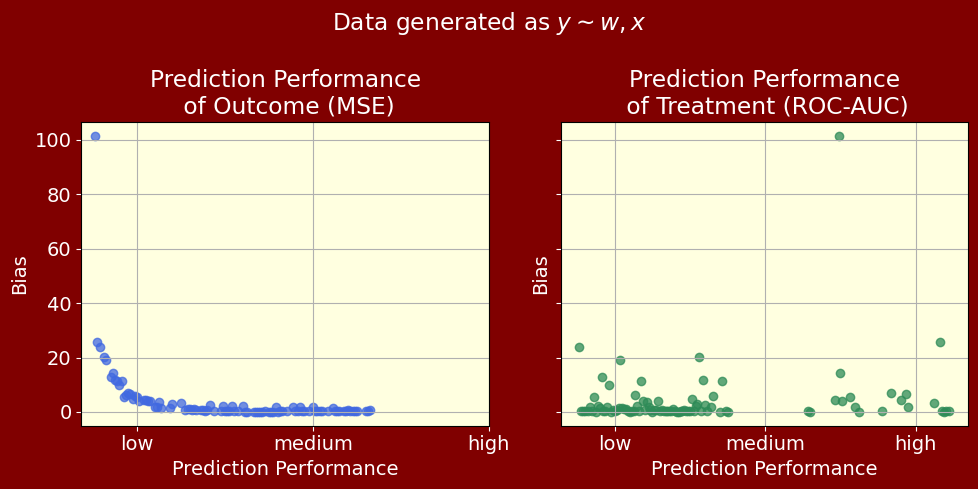

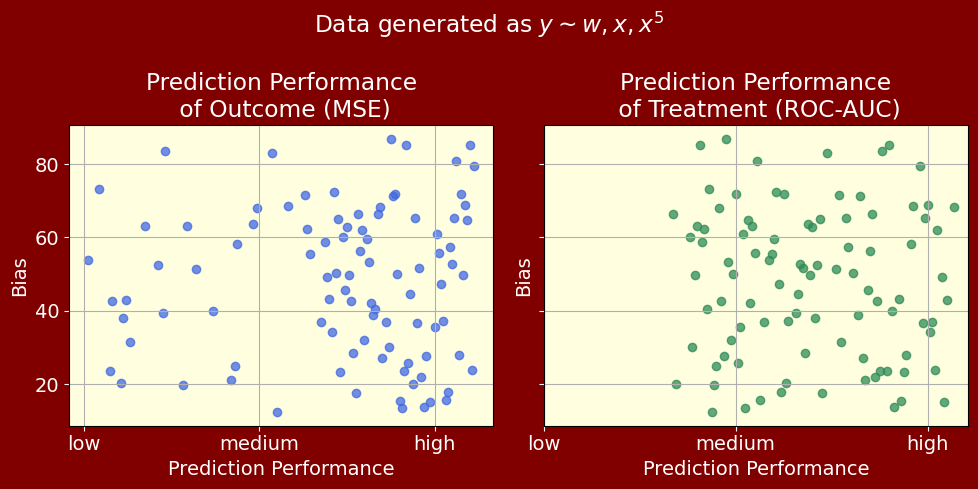

In [123]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

for deg in enumerate(degree_complexity_list):
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(10,5), sharey=True)
    plot_ = df_results.loc[(df_results['complexity']==deg[1]) ]

    ## Remove rows with the 2 highest mse values
    plot_ = plot_.sort_values(by=['y_mse_perc'],ascending=False)[2:]
    plot_ = plot_.sort_values(by=['w_roc_auc_perc'],ascending=False)[2:]
    plot_ = plot_.sort_values(by=['bias'],ascending=False)[2:]

    plot_['bias'] = np.abs(plot_['bias'])

    at0=ax[0].scatter(y=plot_['bias'], x=plot_['y_mse_perc'], alpha=0.75, color='royalblue',label='Outcome (MSE)')
#     plot_corr_data(xe=plot_['y_mse_perc'], ye=plot_['bias'], axes=ax[0], plot_color=at0.get_edgecolor())
    ax[0].set_title('Prediction Performance\n of Outcome (MSE)', color='white')
    
    at1=ax[1].scatter(y=plot_['bias'], x=plot_['w_roc_auc_perc'], alpha=0.75, color='seagreen', label='Treatment (ROC AUC)')
#     plot_corr_data(xe=plot_['w_roc_auc_perc'], ye=plot_['bias'], axes=ax[1], plot_color=at1.get_edgecolor())
    ax[1].set_title('Prediction Performance\n of Treatment (ROC-AUC)', color='white')
    
#     ax[deg[0],1].legend( bbox_to_anchor=(1.04, 1), loc="upper left", fancybox=True)
#     ax[deg[0],1].legend( bbox_to_anchor=(1.04, 1), loc="upper left", fancybox=True)
    
    for e in range(2):
        ax[e].set_xlabel('Prediction Performance')
        ax[e].set_xticks([0.1, 0.5, 0.9])
        ax[e].set_xticklabels(['low','medium','high'])    
        ax[e].set_ylabel(r'Bias')
        ax[e].set_facecolor('lightyellow')
        ax[e].grid()
        ax[e].xaxis.label.set_color('white')
        ax[e].yaxis.label.set_color('white')
        ax[e].tick_params(axis='x', colors='white')
        ax[e].tick_params(axis='y', colors='white')

    
#     fig.suptitle(r'Scatterplots of treatment effect biases\n on outcome and treatment prediction performance\n results from a DML model using unpenalized linear regression and logistic regression to residualize.', color='white')
    
    if deg[1]<=1:
        fig.suptitle(r'Data generated as $y \sim w, x$'.format(deg[1]), color='white')
    else:
        fig.suptitle(r'Data generated as $y \sim w, x, x^{0}$'.format(deg[1]), color='white')

        
    
    plt.tight_layout()
    fig.set_facecolor('maroon')
    
    